This notebook will use a simple model to predict ratings for a user, anime pair:
rating(user, item) = offset + user_bias + item_bias

Put simply, the predicted rating is the sum of three terms. The user_bias refers to whether a user is predisposed to rating higher or lower. For example, a user who gives all perfect scores will have a highly positive user_bias term. The item_bias is similar, except it refers to an anime. So a highly rated anime will have a highly positive anime_bias term. Finally, there's an offset to adjust for the general anime score. This will be initialized to 6.9 (the mean rating in the exploratory analysis) but since this is being run for only users with 10 or more ratings, that number is only a rough guess. Note that this entire program is optimized for users with 10 or more ratings, but the validation and test sets may include users with fewer ratings. 

The objective function will be mean absolute error (MAE) with L2 regularization. This model is implemented in tensorflow, just for the sake of practice. 

Broadly speaking, this code is organized into two parts.

In the first part, I do some basic data prep:

1) Import some packages for plotting
2) Use my animerec package to get data
3) split the data into train, test, and validation sets
4) Define some data structures that'll be used to vectorize computations. 

In the second part, I use tensorflow to implement this simple model, using a validation set for early stopping. I then see the performance on the test set.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')

In [2]:
from animerec.data import get_data
users, anime = get_data()

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(users, test_size = 0.1) #let's split up the dataset into a train and test set.
train, valid = train_test_split(train, test_size = 0.2) #let's split up the dataset into a train and valid set.

In [4]:
from animerec.data import remove_users
train = remove_users(train, 10)

In [5]:
#define validation set
valid_users = valid['user_id']
valid_anime = valid['anime_id']
valid_ratings = valid['rating']

In [6]:
#initialize some local variables
nUsers = len(train.user_id.unique())
nAnime = len(train.anime_id.unique())

# we'll need some data structures in order to vectorize computations
from collections import defaultdict
user_ids = train.user_id
item_ids = train.anime_id

user_index = defaultdict(lambda: -1) # maps a user_id to the index in the bias term.
item_index = defaultdict(lambda: -1) # maps an anime_id to the index in the bias term.

counter = 0
for user in user_ids:
    if user_index[user] == -1:
        user_index[user] = counter
        counter += 1 

counter = 0
for item in item_ids:
    if item_index[item] == -1:
        item_index[item] = counter
        counter += 1 

In [7]:
import tensorflow as tf

In [8]:
y = tf.cast(tf.constant(train['rating'].as_matrix(), shape=[len(train),1]), tf.float32)

In [9]:
def objective(alpha, Bi, Bu, y, lam):
    #construct the full items and user matrix.
    Bi_full = tf.gather(Bi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix())
    Bu_full = tf.gather(Bu, train.user_id.map(lambda _id: user_index[_id]).as_matrix())
    alpha_full = tf.tile(alpha, (len(train), 1))
    
    return tf.reduce_sum(abs(alpha_full+Bi_full+Bu_full-y)) + lam * (tf.reduce_sum(Bi**2) + tf.reduce_sum(Bu**2))

In [10]:
#initialize alpha, Bi, Bu
alpha = tf.Variable(tf.constant([6.9], shape=[1, 1]))
Bi = tf.Variable(tf.constant([0.0]*nAnime, shape=[nAnime, 1]))
Bu = tf.Variable(tf.constant([0.0]*nUsers, shape=[nUsers, 1]))

In [11]:
optimizer = tf.train.AdamOptimizer(0.01)

In [12]:
obj = objective(alpha, Bi, Bu, y, 1)

In [13]:
trainer = optimizer.minimize(obj)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tLoss = []
vLoss = []
prev = 10e10
for iteration in range(500):
    cvalues = sess.run([trainer, obj])
    print("objective = " + str(cvalues[1]))
    tLoss.append(cvalues[1])
    
    if not iteration % 5:
        cAlpha, cBi, cBu, cLoss = sess.run([alpha, Bi, Bu, obj])
        indices = valid_users.map(lambda x: user_index[x])
        bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
        indices = valid_anime.map(lambda x: item_index[x])
        bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
        preds = bu + bi + float(cAlpha)
        MAE = 1.0/len(test) * sum(abs(valid_ratings-preds))
        vLoss.append(MAE)
        if MAE > prev: break
        else: prev = MAE
    
cAlpha, cBi, cBu, cLoss = sess.run([alpha, Bi, Bu, obj])
print("\nFinal train loss is ", cLoss)

objective = 3.58716e+06
objective = 3.53675e+06
objective = 3.4859e+06
objective = 3.43733e+06
objective = 3.40899e+06
objective = 3.39151e+06
objective = 3.37163e+06
objective = 3.35319e+06
objective = 3.33393e+06
objective = 3.31501e+06
objective = 3.29582e+06
objective = 3.27672e+06
objective = 3.25756e+06
objective = 3.23859e+06
objective = 3.21963e+06
objective = 3.20072e+06
objective = 3.18179e+06
objective = 3.16287e+06
objective = 3.14396e+06
objective = 3.12504e+06
objective = 3.10612e+06
objective = 3.0872e+06
objective = 3.06829e+06
objective = 3.04936e+06
objective = 3.03044e+06
objective = 3.0115e+06
objective = 2.99256e+06
objective = 2.97362e+06
objective = 2.95466e+06
objective = 2.93569e+06
objective = 2.91671e+06
objective = 2.89771e+06
objective = 2.8787e+06
objective = 2.85967e+06
objective = 2.84063e+06
objective = 2.82156e+06
objective = 2.80248e+06
objective = 2.78337e+06
objective = 2.76424e+06
objective = 2.74509e+06
objective = 2.72592e+06
objective = 2.70701e

Let's plot the objective and see how it decreases.

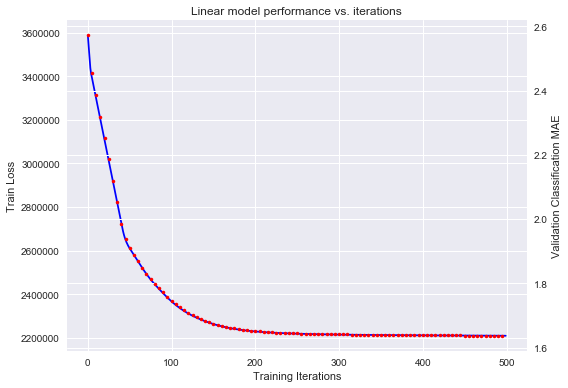

In [15]:
fig, ax1 = plt.subplots()
plt.title('Linear model performance vs. iterations')
ax1.plot(tLoss, 'b-')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Train Loss')

ax2 = ax1.twinx()
ax2.plot(range(0, len(vLoss)*5, 5), vLoss, 'r.')
ax2.set_ylabel('Validation Classification MAE')

fig.tight_layout()

So by 50 iterations, the model hits a bend and from there we see incremental improvement. We can see quite clearly that this model does not overfit. It's a very simple model (that likely underfits the data) and we use L2 regularization, so to that end it's not surprising at all. But it's good to confirm anyway.

Let's test the model on our test data now.

In [16]:
test_users = test['user_id']
test_anime = test['anime_id']
test_ratings = test['rating']

In [17]:
indices = test_users.map(lambda x: user_index[x])
bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
indices = test_anime.map(lambda x: item_index[x])
bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
preds = bu + bi + float(cAlpha)
MAE = 1.0/len(test) * sum(abs(test_ratings-preds))
print ('MAE on test set is: ', float(MAE))

MAE on test set is:  0.9080973264809713


In [18]:
sess.close()

So a simple linear model, with no real user/item interaction gets us within 0.9 on average of a typical anime. That's pretty good as a baseline. What's also impressive is that this test set includes users who have seen maybe even one anime, which the model did not even train on. In the next notebook, we'll be using a simple latent factor method and seeing how much that improves performance. Then, we'll consider using features in the latent factor method.